In [115]:
from collections import Counter
import nltk
import spacy
import re
nlp = spacy.load('en')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
data = pd.read_csv('train.csv')

In [1251]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [33]:
data.drop(columns=['id', 'keyword', 'location'], inplace=True)

In [752]:
data.text[440:500]

440    smoke good fuck eat drink drive nice car wear ...
441                  kill i got court the day after earl
442     @local_arsonist lmao but real live you should go
443    Owner of Chicago-Area Gay Bar Admits to Arson ...
444    Trusting Iran to stop terrorism is like inviti...
445    Big Top Burning The True Story Of An Arsonist ...
446    Stay vigilent. Civil liberties are under const...
447    Credit to @pfannebeckers for inspiring me to r...
448    http://t.co/pTKrXtZjtV  Nashville Theater Atta...
449    BREAKING: Terror Attack On\nPolice Post #Udhampur
450    Demi stans really think Heart Attack sold 5/6 ...
451    it scares me that there's new versions of nucl...
452    ISIL claims suicide bombing at Saudi mosque th...
453    @DatTomm the funniest part about that twitter ...
454    Horrific attack on wife by muslim in Italy htt...
455    Ûª93 blasts accused Yeda Yakub dies in Karach...
456    @etribune  US Drone attack kills 4-suspected m...
457    Suspect in latest theate

## 1. Data analysis

In [524]:
data_analys = data.copy()

We have created dictionary of words (corpus) for disaster and non-disaster tweets seperately. 

In [1048]:
corpus_analys_neg=[]
for sent in data_analys[data_analys['target']==0]['text']:
    for word in sent.split():
        corpus_analys_neg.append(word)

In [1103]:
corpus_analys_pos=[]
for sent in data_analys[data_analys['target']==1]['text']:
    for word in sent.split():
        corpus_analys_pos.append(word)

Below is the plot of number of tweets for disaster and non-disaster tweets. 

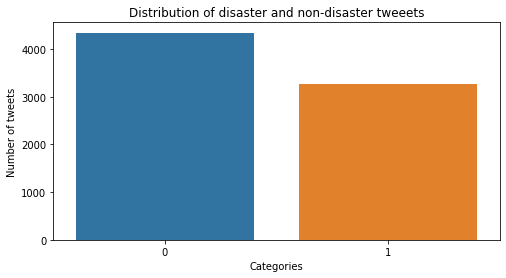

In [1053]:
plt.figure(figsize=(8,4))
sns.countplot(data_analys.target)
plt.title('Distribution of disaster and non-disaster tweeets')
plt.ylabel('Number of tweets')
plt.xlabel('Categories')
plt.show()

We see from the plot that non-disaster tweets are more then disaster tweeets.

In [1086]:
data_analys['word_count']=data_analys['text'].apply(lambda x: len(str(x).split(" ")))

<function matplotlib.pyplot.show(close=None, block=None)>

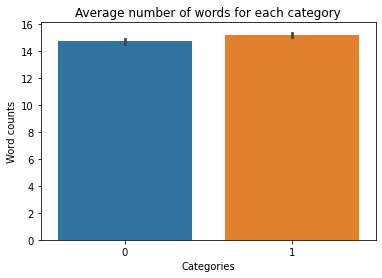

In [1112]:
sns.barplot(y='word_count', x='target', data=data_analys, orient='v')
plt.title('Average number of words for each category')
plt.ylabel('Word counts')
plt.xlabel('Categories')
plt.show

We see from the above plot that average number of words of both tweet types are almost equal.

In [533]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [534]:
data_analys['stopwords'] = data_analys['text'].apply(lambda x: len([x for x in x.split() if x in stop]) )

<function matplotlib.pyplot.show(close=None, block=None)>

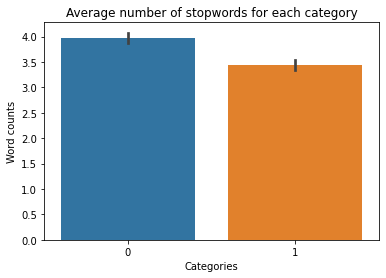

In [1111]:
sns.barplot(y='stopwords', x='target', data=data_analys, orient='v')
plt.title('Average number of stopwords for each category')
plt.ylabel('Word counts')
plt.xlabel('Categories')
plt.show

We see from the above plot that average stopword for both types of tweets are very similar.

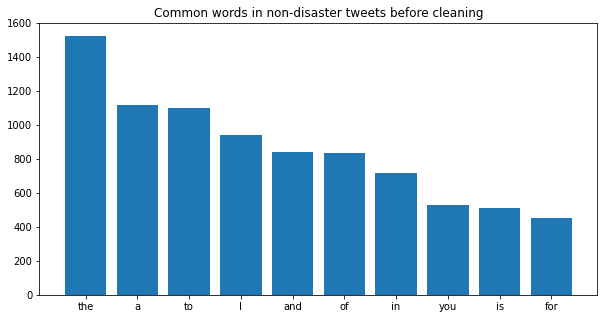

In [1122]:
plt.figure(figsize=(10,5))
from collections import Counter
word_counts1 = Counter(corpus_analys_neg).most_common(10)
dict_word1 = dict(word_counts1)
plt.bar(dict_word1.keys(), dict_word1.values())
plt.title('Common words in non-disaster tweets before cleaning')
plt.show()

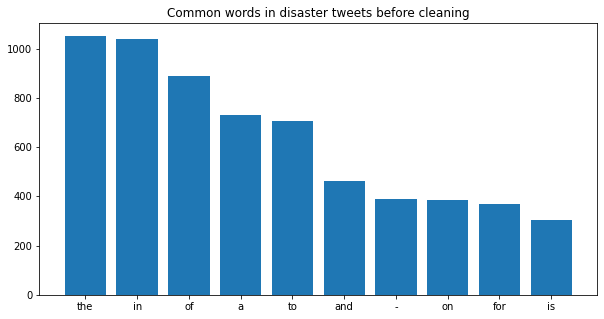

In [1121]:
plt.figure(figsize=(10,5))
from collections import Counter
word_counts2 = Counter(corpus_analys_pos).most_common(10)
dict_word2 = dict(word_counts2)
plt.bar(dict_word2.keys(), dict_word2.values())
plt.title('Common words in disaster tweets before cleaning')
plt.show()

Common words in both tweets are stopwords and punctuations. So we have to clean them first.

## 2. Data Cleaning

In [1124]:
data1 = data.copy()

In [1127]:
data1.text[7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

Below, urls will be removed since they don't contribute to differentiate tweets.

In [1128]:
def remove_URL(text):
    
    return re.sub(r'https?://\S+|www\.\S+', r'',text)

data1['text']=data1['text'].apply(lambda x : remove_URL(x))

In [1129]:
data1.text[7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. '

Stopwords are the words that are frequently encountered but hold relatively unimportant meanings, like nouns, pronouns, adjectives, adverbs etc. So, we are going to remove them. 

In [1130]:
sw = stopwords.words('english')

I have also added some stopwords that are not included in the list. 

In [1131]:
for i in ["i'm", "i'd", "i'll", "there's", "there're", "he's", "he'd", "he'll", "she's", "she'd", "she'll", 
          "they're", "they'd", "they'll", "they've", "we're", "we've", "we'll", "it'll", "it'd"]:
    sw.append(i)

In [1133]:
data1.text[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [1134]:
def remove_stop(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

data1['text'] = data1['text'].apply(remove_stop)

In [1135]:
data1.text[2]

"residents asked 'shelter place' notified officers. evacuation shelter place orders expected"

There are many words starting with '@' since it is used for mention in tweets. They contain addresses which is useless for our analysis. So we are going to remove them. 

In [1136]:
data1.text[7609]

'@aria_ahrary @thetawniest control wild fires california even northern part state. troubling.'

In [1137]:
## removing words start with @
def remove_at(text):
    at_pattern = re.compile("(\s)@\w+|@\w+")
    return at_pattern.sub(r'',text)

data1['text']=data1['text'].apply(lambda x: remove_at(x))

In [1138]:
data1.text[7609]

' control wild fires california even northern part state. troubling.'

Emojis will be removed in the following.

In [1149]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data1['text']=data1['text'].apply(lambda x: remove_emoji(x))

When we analyze the data, there are several repeated symbols like below. We will remove them. 

In [1171]:
def remove_symbol(text):
    return re.sub("\\x89û\s|\\x89û$|\\x89û.*|\\x89.*", r'', text)

data1['text']=data1['text'].apply(lambda x: remove_symbol(x))

Now it is time for removing punctuation.

In [1173]:
def remove_punctuation(text):
    
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

data1['text'] = data1['text'].apply(remove_punctuation)

In [1174]:
data1.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3        people receive wildfires evacuation orders ca...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609     control wild fires california even northern p...
7610                                       volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

There remain some words with numbers and extra white spaces. We will remove them in the following.

In [1175]:
## removing words with numbers
def remove_number(text):
    number_pattern = re.compile('\w*\d\w*')
    return number_pattern.sub(r'',text)

data1['text']=data1['text'].apply(lambda x: remove_number(x))

In [1177]:
def remove_nonascii(text):
    nonascii_pattern = re.compile('[^\x00-\x7F]+')
    return nonascii_pattern.sub(r'', text)

data1['text']=data1['text'].apply(lambda x: remove_nonascii(x))

In [1178]:
## removing words starts with aa..
def remove_aa(text):
    aa_pattern = re.compile('aa\s|aa$')
    return aa_pattern.sub(r'',text)

data1['text']=data1['text'].apply(lambda x: remove_aa(x))

Below we remove some abbreviations that are mostly used in tweets like 'tbt', 'rt', etc.

In [1179]:
## removing specific unusefull words...
def remove_words(text):
    word_pattern = re.compile('pm\s|pm$|am\s|am$|tbt\s|tbt$|rt\s|rt$|gmt\s|gmt$|pt\s|pt$|')
    return word_pattern.sub(r'',text)

data1['text']=data1['text'].apply(lambda x: remove_words(x))

Finally we remove all white spaces.

In [1180]:
def remove_whites(text):
    
    return ' '.join(text.split())

data1['text']=data1['text'].apply(lambda x: remove_whites(x))

In [1181]:
data1.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [1183]:
data1.rename(columns = {'text':'text', 'target':'target_dis'}, inplace=True)

In [1184]:
data1.head()

,text,target_dis
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


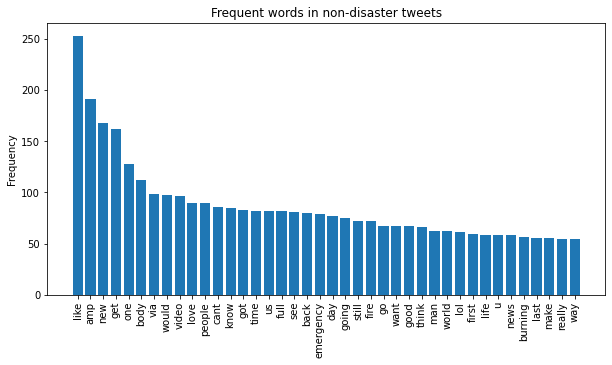

In [1185]:
from collections import Counter
word_counts = Counter(corpus_neg).most_common(40)
dict_word = dict(word_counts)
plt.figure(figsize=(10,5))
plt.bar(dict_word.keys(), dict_word.values())
plt.title('Frequent words in non-disaster tweets')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

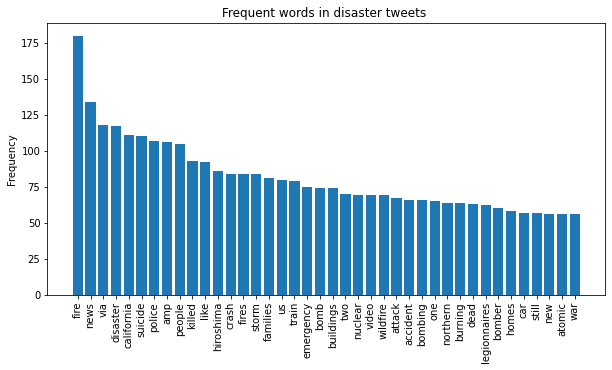

In [1186]:
from collections import Counter
word_counts = Counter(corpus_pos).most_common(40)
dict_word = dict(word_counts)
plt.figure(figsize=(10,5))
plt.bar(dict_word.keys(), dict_word.values())
plt.title('Frequent words in disaster tweets ')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

#### Tokenization and Lemmatization

In [1213]:
data2= data1.copy()

In [1214]:
nlp = spacy.load('en')
doc = data2['text'].apply(nlp)

Below, we convert words into lemmas that are basically the dictionary forms of the words. For example, `run`, `runs`, `ran` and `running` are forms of the same lexeme, with `run` as the lemma. 

In [1215]:
data2.text[2]

'residents asked shelter place notified officers evacuation shelter place orders expected'

In [1216]:
##lemmatization

for i, sent in enumerate(doc):
    data2.loc[i, 'lemma']=' '.join([token.lemma_ for token in sent])

In [1217]:
data2.lemma[2]

'resident ask shelter place notify officer evacuation shelter place order expect'

We have finished data cleaning. Data is ready for feature extraction.

### More cleaning after modelling

In [1279]:
data2.lemma[0]

'deeds reason earthquake may allah forgive '

In [1278]:
data2['lemma']=data2['lemma'].apply(lambda text: re.sub('-PRON-\s|-PRON-$',r'',text))

In [1230]:
data2['lemma']=data2['lemma'].apply(lambda text: re.sub('aaaaaaallll\s|aaaaaaallll$',r'all',text))

In [1234]:
data2['lemma']=data2['lemma'].apply(lambda text: re.sub('aaaaaand\s|aaaaaand$|aannnnd\s|aannnnd$',r'and',text))

In [1280]:
def remove_whites(text):
    
    return ' '.join(text.split())

data1['text']=data1['text'].apply(lambda x: remove_whites(x))

## 3. Feature Extraction

### 1. Bag of Words

In [1281]:
data_bow= data2.copy()

In [1236]:
## bag of words using lemmas 

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', lowercase=False)
X = vectorizer.fit_transform(data_bow["lemma"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_bow = pd.concat([bow_df, data_bow[["lemma", "target_dis"]]], axis=1)

In [1242]:
data_bow.drop(columns=['PRON'], inplace=True)

In [1244]:
data_bow.head()

,aaarrrgghhh,aampb,aampw,aan,aaok,aar,aashiqui,ab,aba,abalcony,...,zone,zonesthank,zoom,zouma,zrnf,zss,zurich,zzzz,lemma,target_dis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,deeds reason earthquake may allah forgive -PRON-,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,forest fire near la ronge sask canada,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,resident ask shelter place notify officer evac...,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,people receive wildfire evacuation order calif...,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,get send photo ruby alaska smoke wildfire pour...,1


#### Logistic Regression Model with BoWs

In [1245]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_bow['target_dis']
X = np.array(data_bow.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))


----------------------Logistic Regression Scores----------------------
Training set score: 0.9513904094591635

Test set score: 0.7908732764281025


Train set score is very high but test score is much lower than it. This shows overfitting. 

Now, we will remove words that appear only once and build another model. 

In [1248]:
data_bow_2 = data2.copy()

In [1249]:
## bag of words using lemmas min_df=2

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', lowercase=False, min_df=2)
X = vectorizer.fit_transform(data_bow_2["lemma"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_bow_2 = pd.concat([bow_df, data_bow_2[["lemma", "target_dis"]]], axis=1)

In [1254]:
data_bow_2.drop(columns=['PRON'], inplace=True)

In [1255]:
data_bow_2.head()

,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abia,ability,ablaze,...,zionism,zionist,zip,zippednews,zombie,zone,zouma,zss,lemma,target_dis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,deeds reason earthquake may allah forgive -PRON-,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,forest fire near la ronge sask canada,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,resident ask shelter place notify officer evac...,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,people receive wildfire evacuation order calif...,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,get send photo ruby alaska smoke wildfire pour...,1


Number of columns has been decreased from 12675 to 5047. 

In [1256]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_bow_2['target_dis']
X = np.array(data_bow_2.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))



----------------------Logistic Regression Scores----------------------
Training set score: 0.9216115611999124

Test set score: 0.7859487852921865


This time, training set score is decreased but model is still overfitting. We will set min_df=3 and build a model again.

In [1260]:
data_bow_3 = data2.copy()

In [1261]:
## bag of words using lemmas min_df=3

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', lowercase=False, min_df=3)
X = vectorizer.fit_transform(data_bow_3["lemma"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_bow_3= pd.concat([bow_df, data_bow_3[["lemma", "target_dis"]]], axis=1)

In [1263]:
data_bow_3.drop(columns=['PRON'], inplace=True)

In [1264]:
data_bow_3.head()

,aba,abandon,abbswinston,abc,abcnew,abe,ability,ablaze,able,abomination,...,yrs,yugvani,yyc,zayn,zionist,zombie,zone,zouma,lemma,target_dis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,deeds reason earthquake may allah forgive -PRON-,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,forest fire near la ronge sask canada,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,resident ask shelter place notify officer evac...,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,people receive wildfire evacuation order calif...,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,get send photo ruby alaska smoke wildfire pour...,1


We have less columns now. 

In [1265]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_bow_3['target_dis']
X = np.array(data_bow_3.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))



----------------------Logistic Regression Scores----------------------
Training set score: 0.9108824173417999

Test set score: 0.7905449770190414


### 2-Grams Approach

A different approach to Bag of Words is n-grams method. We will use 2-grams and 3-grams.

In [1282]:
data_2grams = data2.copy()

In [1283]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word',  lowercase=False,ngram_range= (2,2))
X = vectorizer.fit_transform(data_2grams["lemma"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_2grams = pd.concat([bow_df, data_2grams[["lemma", "target_dis"]]], axis=1)

In [1284]:
data_2grams.head(5)

,aampb pipeliner,aampw help,aan den,aaok lemme,aar ambulancewe,aashiqui actress,ab resin,aba woman,abandon aircraft,abandon cabin,...,zone rove,zone war,zonesthank god,zoom one,zouma absolutely,zouma flatten,zss vs,zurich swiss,lemma,target_dis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,deeds reason earthquake may allah forgive,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,forest fire near la ronge sask canada,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,resident ask shelter place notify officer evac...,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,people receive wildfire evacuation order calif...,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,get send photo ruby alaska smoke wildfire pour...,1


#### Logistic Regression with 2-grams

In [1285]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_2grams['target_dis']
X = np.array(data_2grams.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))



----------------------Logistic Regression Scores----------------------
Training set score: 0.9719728486971754

Test set score: 0.7344057780695995


This time, we will keep single both single words and 2-grams together. 

In [1286]:
data_12grams = data2.copy()

In [1287]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word',  lowercase=False,ngram_range= (1,2))
X = vectorizer.fit_transform(data_12grams["lemma"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_12grams = pd.concat([bow_df, data_12grams[["lemma", "target_dis"]]], axis=1)

In [1289]:
data_12grams.head()

,aaarrrgghhh,aampb,aampb pipeliner,aampw,aampw help,aan,aan den,aaok,aaok lemme,aar,...,zouma absolutely,zouma flatten,zrnf,zss,zss vs,zurich,zurich swiss,zzzz,lemma,target_dis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,deeds reason earthquake may allah forgive,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,forest fire near la ronge sask canada,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,resident ask shelter place notify officer evac...,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,people receive wildfire evacuation order calif...,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,get send photo ruby alaska smoke wildfire pour...,1


In [1288]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_12grams['target_dis']
X = np.array(data_12grams.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))




----------------------Logistic Regression Scores----------------------
Training set score: 0.976571053207795

Test set score: 0.7954694681549573


When we keep single words and 2-grams together, we have obtained better results. We will try removing uncommon words and test the same model again. 

In [1291]:
data_123grams = data2.copy()

In [1292]:
## min_df = 3, ngram_range= (1,2)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word',  lowercase=False,ngram_range= (1,2), min_df=3)
X = vectorizer.fit_transform(data_123grams["lemma"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_123grams = pd.concat([bow_df, data_123grams[["lemma", "target_dis"]]], axis=1)

In [1293]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_123grams['target_dis']
X = np.array(data_123grams.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))



----------------------Logistic Regression Scores----------------------
Training set score: 0.9213925990803591

Test set score: 0.788575180564675


### TF-IDF Approach

In [1294]:
data_tfidf= data2.copy()

In [1307]:
## min_df=2
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, lowercase=False)

# applying the vectorizer
X = vectorizer.fit_transform(data_tfidf["lemma"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_tfidf = pd.concat([tfidf_df, data_tfidf[["lemma", "target_dis"]]], axis=1)

In [1296]:
data_tfidf.head(5)

,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abia,ability,ablaze,...,zionism,zionist,zip,zippednews,zombie,zone,zouma,zss,lemma,target_dis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deeds reason earthquake may allah forgive,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,forest fire near la ronge sask canada,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resident ask shelter place notify officer evac...,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,people receive wildfire evacuation order calif...,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,get send photo ruby alaska smoke wildfire pour...,1


### Logistic Regression with Tf-Idf

In [1297]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_tfidf['target_dis']
X = np.array(data_tfidf.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.8743157433763958

Test set score: 0.793499671700591


With Tf-Idf, test score improved a little bit but this time model reduced overfitting.

Now, we will apply 2-grams to tf-idf approach. 

In [1298]:
data_tfidf_22= data2.copy()

In [1302]:
## min_df=2, ngram_range=(2,2)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, lowercase=False, ngram_range=(2,2))

# applying the vectorizer
X = vectorizer.fit_transform(data_tfidf_22["lemma"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_tfidf_22 = pd.concat([tfidf_df, data_tfidf_22[["lemma", "target_dis"]]], axis=1)

In [1303]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_tfidf_22['target_dis']
X = np.array(data_tfidf_22.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.8235165316400263

Test set score: 0.7363755745239658


Inserting 2-grams reduced the performance of the model.

Instead of 2-grams, we will try removing words that appears less than 3 times in all documents.

In [1304]:
data_tfidf_3= data2.copy()

In [1305]:
## min_df=3
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=3, use_idf=True, norm=u'l2', smooth_idf=True, lowercase=False)

# applying the vectorizer
X = vectorizer.fit_transform(data_tfidf_3["lemma"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_tfidf_3 = pd.concat([tfidf_df, data_tfidf_3[["lemma", "target_dis"]]], axis=1)

In [1306]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_tfidf_3['target_dis']
X = np.array(data_tfidf_3.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.8684037661484563

Test set score: 0.7951411687458962


Model performance increased a bit more than the model with min_df=2.

### Word2Vec

We use a final approach for feature engineering, namely Word2Vec.

In [1335]:
data_word2vec = data2.copy()

In [1336]:
import gensim
import warnings
warnings.filterwarnings("ignore")


model1 = gensim.models.Word2Vec(
    data_word2vec["lemma"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

In [1337]:
word2vec_arr = np.zeros((data_word2vec.shape[0],100))

for i, sentence in enumerate(data_word2vec["lemma"]):
    word2vec_arr[i,:] = np.mean([model1[lemma] for lemma in sentence], axis=0)

word2vec_arr = pd.DataFrame(word2vec_arr)
data_word2vec = pd.concat([data_word2vec[["target_dis", "lemma"]],word2vec_arr], axis=1)
data_word2vec.dropna(inplace=True)

data_word2vec.head()

,target_dis,lemma,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,1,deeds reason earthquake may allah forgive,0.056922,0.164624,-0.083723,0.089162,-0.006487,0.037945,-0.050944,0.053486,...,0.057478,-0.058441,-0.054603,-0.155688,-0.209076,0.000846,-0.143593,-0.064243,0.185596,0.117643
1,1,forest fire near la ronge sask canada,0.060277,0.166590,-0.078193,0.073723,0.009763,0.023502,-0.020445,0.049496,...,0.052591,-0.069445,-0.029355,-0.166402,-0.210763,0.023176,-0.138070,-0.083936,0.162599,0.099778
2,1,resident ask shelter place notify officer evac...,0.066689,0.154519,-0.125050,0.053231,0.002072,0.029694,-0.071555,0.038849,...,0.041421,-0.097197,-0.072598,-0.173655,-0.164762,0.070325,-0.142533,-0.093090,0.132454,0.099096
3,1,people receive wildfire evacuation order calif...,0.068864,0.181199,-0.092173,0.045284,0.017526,0.018162,-0.043599,0.047741,...,0.070997,-0.082225,-0.077213,-0.190998,-0.150294,0.050184,-0.116984,-0.079039,0.198876,0.125751
4,1,get send photo ruby alaska smoke wildfire pour...,0.065049,0.108286,-0.097758,0.078894,-0.016895,0.064657,-0.077155,0.036124,...,0.072197,-0.047028,-0.052295,-0.127663,-0.195309,0.023115,-0.123895,-0.044071,0.132321,0.099286


In [1338]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_word2vec['target_dis']
X = np.array(data_word2vec.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))




----------------------Logistic Regression Scores----------------------
Training set score: 0.6184500220167327

Test set score: 0.6251651254953765


In [1326]:
data_word2vec_2 = data2.copy()

In [1327]:
# min_count=2
model2 = gensim.models.Word2Vec(
    data_word2vec_2["lemma"],
    workers=4,
    min_count=2,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

In [1329]:
word2vec_arr_2 = np.zeros((data_word2vec_2.shape[0],100))

for i, sentence in enumerate(data_word2vec_2["lemma"]):
    word2vec_arr_2[i,:] = np.mean([model2[lemma] for lemma in sentence], axis=0)

word2vec_arr_2 = pd.DataFrame(word2vec_arr_2)
data_word2vec_2 = pd.concat([data_word2vec_2[["target_dis", "lemma"]],word2vec_arr_2], axis=1)
data_word2vec_2.dropna(inplace=True)

data_word2vec_2.head()

,target_dis,lemma,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,1,deeds reason earthquake may allah forgive,-0.008649,0.095383,-0.053119,0.033385,0.040330,-0.024185,0.019939,0.087634,...,-0.136369,-0.126104,-0.089092,-0.137886,-0.069947,-0.038776,-0.130418,-0.024680,0.360111,0.088754
1,1,forest fire near la ronge sask canada,-0.025542,0.068482,-0.071577,0.054988,0.021287,0.026424,-0.039528,0.077307,...,-0.121051,-0.128082,-0.092984,-0.136123,-0.067591,-0.004426,-0.093599,0.002128,0.306528,0.073196
2,1,resident ask shelter place notify officer evac...,-0.009205,0.093215,-0.060614,0.028165,0.060727,-0.019257,0.039136,0.106928,...,-0.123487,-0.114250,-0.056452,-0.176502,-0.107108,-0.050948,-0.096096,0.000268,0.311232,0.088973
3,1,people receive wildfire evacuation order calif...,-0.015760,0.074498,-0.050888,0.047128,0.028614,-0.007022,0.016933,0.086546,...,-0.106522,-0.117333,-0.034021,-0.176878,-0.105095,-0.079130,-0.112646,0.018051,0.368355,0.117936
4,1,get send photo ruby alaska smoke wildfire pour...,0.001089,0.104044,-0.050769,0.027997,0.073956,-0.049520,0.061063,0.126301,...,-0.159555,-0.109521,-0.091614,-0.144663,-0.074904,-0.047707,-0.128053,-0.024092,0.311842,0.093999


In [1330]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_word2vec_2['target_dis']
X = np.array(data_word2vec_2.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))




----------------------Logistic Regression Scores----------------------
Training set score: 0.6213121972699251

Test set score: 0.6132760898282695


When we set min_count=2, results did not change much. 

In [1346]:
data_word2vec_3 = data2.copy()

In [1347]:
# min_count=3
model3 = gensim.models.Word2Vec(
    data_word2vec_3["lemma"],
    workers=4,
    min_count=3,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

In [1348]:
word2vec_arr_3 = np.zeros((data_word2vec_3.shape[0],100))

for i, sentence in enumerate(data_word2vec_3["lemma"]):
    word2vec_arr_3[i,:] = np.mean([model3[lemma] for lemma in sentence], axis=0)

word2vec_arr_3 = pd.DataFrame(word2vec_arr_3)
data_word2vec_3 = pd.concat([data_word2vec_3[["target_dis", "lemma"]],word2vec_arr_3], axis=1)
data_word2vec_3.dropna(inplace=True)

data_word2vec_3.head()

,target_dis,lemma,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,1,deeds reason earthquake may allah forgive,0.060970,0.137000,-0.118488,0.130242,-0.028307,0.081751,-0.092812,0.031848,...,-0.117149,-0.138275,-0.122775,-0.095185,-0.018489,0.093556,-0.010661,0.037169,-0.266809,0.118480
1,1,forest fire near la ronge sask canada,0.066594,0.129053,-0.139471,0.136685,-0.038301,0.093921,-0.097479,0.038164,...,-0.120564,-0.152344,-0.104213,-0.104963,-0.031330,0.098762,-0.019124,0.035583,-0.257894,0.103572
2,1,resident ask shelter place notify officer evac...,0.073378,0.103560,-0.141146,0.170336,-0.037539,0.140125,-0.115132,0.015263,...,-0.077485,-0.165908,-0.091411,-0.105902,-0.032027,0.094961,0.033982,0.070668,-0.334213,0.137750
3,1,people receive wildfire evacuation order calif...,0.072482,0.092884,-0.128559,0.186121,-0.042536,0.163026,-0.120862,0.014906,...,-0.058199,-0.179048,-0.056946,-0.116232,-0.055621,0.083055,0.045940,0.060849,-0.300160,0.120516
4,1,get send photo ruby alaska smoke wildfire pour...,0.063520,0.115670,-0.135426,0.158166,-0.054061,0.114481,-0.108338,0.009744,...,-0.095599,-0.131670,-0.115167,-0.093277,-0.009134,0.074206,-0.003439,0.078870,-0.274760,0.130878


In [1349]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_word2vec_3['target_dis']
X = np.array(data_word2vec_3.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))





----------------------Logistic Regression Scores----------------------
Training set score: 0.6043593130779392

Test set score: 0.6083223249669749


## Cross Validation

In [1331]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [1339]:
## word2vec model
y = data_word2vec['target_dis']
X = np.array(data_word2vec.drop(['lemma','target_dis'], 1))

In [1340]:
log_reg = LogisticRegression()


parameters = {"C": [10 ** x for x in range (-5, 5, 1)],
              "penalty": ['l1', 'l2']
             }
grid_cv = GridSearchCV(estimator=log_reg,
                       param_grid = parameters,
                       cv = 10
                      )
grid_cv.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l1', 'l2']})

In [1341]:
print("Best Parameters : ", grid_cv.best_params_)
print("Best Score      : ", grid_cv.best_score_)

Best Parameters :  {'C': 10, 'penalty': 'l2'}
Best Score      :  0.6060766182298547


In [1350]:
#using best parameters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_word2vec['target_dis']
X = np.array(data_word2vec.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression(C=10)


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))





----------------------Logistic Regression Scores----------------------
Training set score: 0.6296785557023338

Test set score: 0.6225231175693527


In [1342]:
## tf-idf model data_tfidf_3

y = data_tfidf_3['target_dis']
X = np.array(data_tfidf_3.drop(['lemma','target_dis'], 1))

log_reg = LogisticRegression()


parameters = {"C": [10 ** x for x in range (-5, 5, 1)],
              "penalty": ['l1', 'l2']
             }
grid_cv = GridSearchCV(estimator=log_reg,
                       param_grid = parameters,
                       cv = 10
                      )
grid_cv.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l1', 'l2']})

In [1343]:
print("Best Parameters : ", grid_cv.best_params_)
print("Best Score      : ", grid_cv.best_score_)

Best Parameters :  {'C': 1, 'penalty': 'l2'}
Best Score      :  0.6663640188866011


In [1344]:
print("Best Index : ", grid_cv.best_index_)
print("Best Estimator      : ", grid_cv.best_estimator_)

Best Index :  11
Best Estimator      :  LogisticRegression(C=1)


In [1351]:
## using best parameters

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_tfidf_3['target_dis']
X = np.array(data_tfidf_3.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.8684037661484563

Test set score: 0.7951411687458962


In [1356]:
## bag of words 

y = data_bow_3['target_dis']
X = np.array(data_bow_3.drop(['lemma','target_dis'], 1))

log_reg = LogisticRegression()


parameters = {"C": [10 ** x for x in range (-5, 5, 1)],
              "penalty": ['l2']
             }
grid_cv = GridSearchCV(estimator=log_reg,
                       param_grid = parameters,
                       cv = 10
                      )
grid_cv.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'penalty': ['l2']})

In [1357]:
print("Best Parameters : ", grid_cv.best_params_)
print("Best Score      : ", grid_cv.best_score_)

Best Parameters :  {'C': 0.1, 'penalty': 'l2'}
Best Score      :  0.681467781376211


In [1358]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

Y = data_bow_3['target_dis']
X = np.array(data_bow_3.drop(['lemma','target_dis'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression(C=0.1)


lr.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))




----------------------Logistic Regression Scores----------------------
Training set score: 0.8401576527260783

Test set score: 0.7902166776099803
